In [1]:

import InvertCnnConverter
import torch
import Unet

In [2]:
device=torch.device("cuda:0")
torch.nn.Conv2d(1,1,3,1,1).to(device)(torch.ones(1,1,10,10).to(device)) # for cudnn kernel init. do not delete it. you must run it first

def debug_memory(title, v=False):
    alloc = torch.cuda.memory_allocated(device)/1024/1024
    max_alloc = torch.cuda.max_memory_allocated(device)/1024/1024
    reserved = torch.cuda.memory_reserved(device)/1024/1024
    max_reserved = torch.cuda.max_memory_reserved(device)/1024/1024
    if v:
        print(f'[{title:>10s}] alloc={alloc:.0f} / {max_alloc:.0f} MB, reserved={reserved:.0f} / {max_reserved:.0f} MB ')
    return alloc, max_alloc

class Memlog:
    def __init__(self, name):
        self.name = name

    def __call__(self, fn):
        def wrap(*args, **kwargs):
            torch.cuda.empty_cache()
            torch.cuda.reset_max_memory_allocated(device)
            torch.cuda.reset_max_memory_cached(device)    
            a0, ma0 = debug_memory("")
            fn(*args, **kwargs)
            a1, ma1 = debug_memory("")
            torch.cuda.empty_cache()
            torch.cuda.reset_max_memory_allocated(device)
            torch.cuda.reset_max_memory_cached(device)
            # print(f'[{self.name:>10s}]: {ma1-ma0:.0f}')
            #print(f'{ma1-ma0:.0f}')
            return ma1-ma0
        return wrap

    
@Memlog("original")
def original(size, channel, device):   
    input = torch.ones(1,channel,size,size, device=device, requires_grad=True)
    plain_model = Unet.UNet(n_channels=channel, n_classes=1).to(device)
    out = plain_model(input)
    loss = out.sum()
    loss.backward()
    
@Memlog("converted")
def converted(size, channel, device, option):   
    input = torch.ones(1,channel,size,size, requires_grad=True)
    if 'stitchable' not in option : 
        input = input.to(device)
    plain_model = Unet.UNet(n_channels=channel, n_classes=1)
    InvertCnnConverter.convert_module(plain_model, last_module_name='outc', inplace=True, option=option)
    invert_model = plain_model.to(device)
    out = invert_model(input)
    loss = out.sum()
    loss.backward()
    
import matplotlib.pyplot as plt
import numpy as np
def make_plot(experiments_result) : 
    experiments_result_np = np.array(experiments_result)
    x = list(map(lambda x : "%d,%d" % (x[0].astype(int),x[1].astype(int)), experiments_result_np))
    o = experiments_result_np[:,2]
    c = experiments_result_np[:,3]
    i = experiments_result_np[:,4]
    s = experiments_result_np[:,5]
    c_i = experiments_result_np[:,6]
    c_s = experiments_result_np[:,7]
    s_i = experiments_result_np[:,8]
    csi = experiments_result_np[:,9]

    plt.rcParams["figure.figsize"] = (14,14)

    plt.plot(x, csi, label='our system')
    plt.plot(x, c, label='our system - checkpoint only')
    plt.plot(x, i, label='our system - invertible only')
    plt.plot(x, s, label='our system - stitchable only')
    plt.plot(x, c_i, label='our system - checkpoint+invertible')
    plt.plot(x, c_s, label='our system - checkpoint+stitchable')
    plt.plot(x, s_i, label='our system - stitchable+invertible')
    plt.plot(x, o, label='without our system - plain')
    plt.legend()
    plt.xticks(rotation=90)

    plt.xlabel("image size, image channel")
    plt.ylabel("GPU alloc(MB)")
    plt.title("Unet memory alloc size with/without Our System")

    plt.show()

/opt/conda/envs/memcnn/lib/python3.6/site-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
/opt/conda/envs/memcnn/lib/python3.6/site-packages/torch/cuda/memory.py:289: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


size:100x100, channel:1, original:307.22, c:279.41, i:216.22, s:303.67, ci:205.99, cs:278.47, si:214.24, csi:199.53
size:100x100, channel:2, original:307.26, c:279.45, i:216.26, s:303.67, ci:206.03, cs:278.47, si:214.24, csi:199.53
size:100x100, channel:4, original:307.34, c:279.53, i:216.33, s:303.67, ci:206.11, cs:278.47, si:214.24, csi:199.53
size:100x100, channel:8, original:307.50, c:279.69, i:216.48, s:303.67, ci:206.26, cs:278.47, si:214.24, csi:199.53
size:200x200, channel:1, original:516.98, c:392.36, i:414.93, s:505.52, ci:278.46, cs:391.22, si:374.28, csi:260.20
size:200x200, channel:2, original:517.14, c:392.51, i:415.08, s:505.52, ci:278.61, cs:391.22, si:374.28, csi:260.20
size:200x200, channel:4, original:517.45, c:392.82, i:415.39, s:505.52, ci:278.92, cs:391.22, si:374.28, csi:260.20
size:200x200, channel:8, original:516.58, c:393.21, i:415.63, s:505.52, ci:279.73, cs:391.22, si:374.28, csi:260.20
size:300x300, channel:1, original:761.84, c:451.10, i:808.33, s:715.72, 

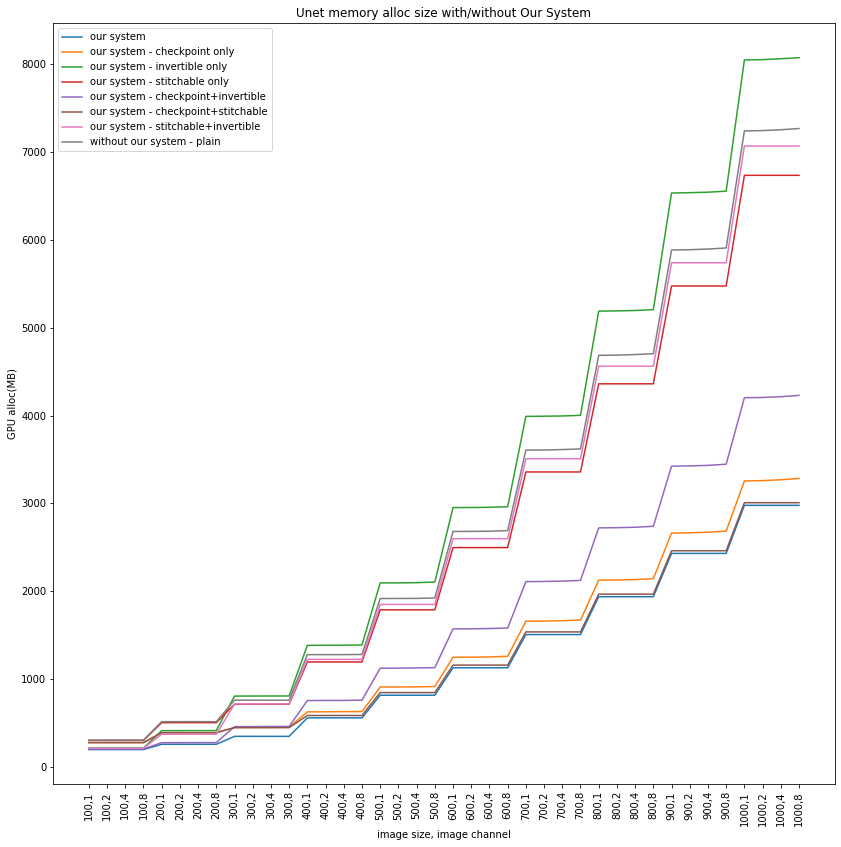

In [3]:
experiments_result = []

for size in range(100, 1001, 100) : 
    for ch in  2 ** np.arange(0,4) : 
        original_size = original(size,ch,device)
        c = converted(size,ch,device, option=['checkpoint'])
        i = converted(size,ch,device, option=['invertible'])
        s = converted(size,ch,device, option=['stitchable'])
        c_i = converted(size,ch,device, option=['checkpoint', 'invertible'])
        c_s = converted(size,ch,device, option=['checkpoint', 'stitchable'])
        s_i = converted(size,ch,device, option=['invertible', 'stitchable'])
        csi = converted(size,ch,device, option=['checkpoint', 'invertible', 'stitchable'])

        print("size:%dx%d, channel:%d, original:%.2f, c:%.2f, i:%.2f, s:%.2f, ci:%.2f, cs:%.2f, si:%.2f, csi:%.2f" \
              % (size, size, ch, original_size, c,i,s,c_i,c_s,s_i,csi))
        
        experiments_result.append((size, ch, original_size, c,i,s,c_i,c_s,s_i,csi))
        
make_plot(experiments_result)